In [4]:
import pandas as pd
import unicodedata
import re
import jellyfish as jf
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import datetime
import json

# Datos

Los datos vienen en un jsonl, leemos los datos

In [113]:
lis = [] 
with open("bulk-3872554942703.jsonl", "r") as archivo: 

    for linea in archivo: 
 
        objeto_json = json.loads(linea) 
        lis.append(objeto_json)




In [114]:
len(lis)

105682

hay 105682 registros, mostramos los primeros 10 registros

In [115]:
lis[1:10]

[{'id': 'gid://shopify/LineItem/13278928699631',
  'product': {'id': 'gid://shopify/Product/7970498904303'},
  'quantity': 1,
  'title': 'ECOFILTRO PELTRE NEGRO',
  'variant': {'id': 'gid://shopify/ProductVariant/43700870676719'},
  'variantTitle': None,
  'vendor': 'NULL',
  'name': 'ECOFILTRO PELTRE NEGRO',
  'totalDiscountSet': {'shopMoney': {'amount': '0.0'}},
  '__parentId': 'gid://shopify/Order/5298910265583'},
 {'id': 'gid://shopify/Order/5298910331119',
  'cancelReason': None,
  'cancelledAt': None,
  'closedAt': None,
  'createdAt': '2023-08-20T17:24:29Z',
  'currencyCode': 'MXN',
  'currentTotalPriceSet': {'shopMoney': {'amount': '8896.5'}},
  'customer': {'id': 'gid://shopify/Customer/6965136228591',
   'emailMarketingConsent': {'marketingState': 'NOT_SUBSCRIBED'},
   'createdAt': '2023-07-14T07:47:56Z',
   'state': 'DISABLED',
   'defaultAddress': None,
   'numberOfOrders': '1',
   'amountSpent': {'amount': '8896.5'}},
  'displayFinancialStatus': 'PAID',
  'displayFulfillme

observamos que cada registro json tiene diferente estructura, realicemos una busqueda para identificar las distintas estructuras que hay

In [116]:
def identificar_estructura(objeto):
    keys = set(objeto.keys())
    return keys

estructuras_diferentes = set()

with open("bulk-3872554942703.jsonl", "r") as archivo:
    for linea in archivo:
        objeto_json = json.loads(linea)
        estructura_actual = identificar_estructura(objeto_json)
        estructuras_diferentes.add(tuple(estructura_actual))
        
for estructura in estructuras_diferentes:
    print("Estructura:", estructura)

Estructura: ('name', 'totalDiscountSet', 'variantTitle', 'product', 'variant', 'vendor', 'id', '__parentId', 'quantity', 'title')
Estructura: ('shippingAddress', 'subtotalLineItemsQuantity', 'paymentGatewayNames', 'totalDiscountsSet', 'createdAt', 'id', 'displayFulfillmentStatus', 'currentTotalPriceSet', 'customer', 'processedAt', 'cancelledAt', 'totalPriceSet', 'closedAt', 'displayFinancialStatus', 'cancelReason', 'currencyCode')


In [117]:
estructuras_diferentes

{('name',
  'totalDiscountSet',
  'variantTitle',
  'product',
  'variant',
  'vendor',
  'id',
  '__parentId',
  'quantity',
  'title'),
 ('shippingAddress',
  'subtotalLineItemsQuantity',
  'paymentGatewayNames',
  'totalDiscountsSet',
  'createdAt',
  'id',
  'displayFulfillmentStatus',
  'currentTotalPriceSet',
  'customer',
  'processedAt',
  'cancelledAt',
  'totalPriceSet',
  'closedAt',
  'displayFinancialStatus',
  'cancelReason',
  'currencyCode')}

observamos que hay 2 diferentes estructuras, vamos a crear 2 dataframe, 1 a partir de cada estructura

In [118]:
keys_structure_1 = ('name', 'totalDiscountSet', 'variantTitle', 'product', 'variant', 'vendor', 'id', '__parentId', 'quantity', 'title')
keys_structure_2 = ('shippingAddress', 'subtotalLineItemsQuantity', 'paymentGatewayNames', 'totalDiscountsSet', 'createdAt', 'id', 'displayFulfillmentStatus', 'currentTotalPriceSet', 'customer', 'processedAt', 'cancelledAt', 'totalPriceSet', 'closedAt', 'displayFinancialStatus', 'cancelReason', 'currencyCode')

data_structure_1 = [d for d in lis if all(key in d for key in keys_structure_1)]
data_structure_2 = [d for d in lis if all(key in d for key in keys_structure_2)]

df_1 = pd.DataFrame(data_structure_1)
df_2 = pd.DataFrame(data_structure_2)

In [119]:
df_1

,id,product,quantity,title,variant,variantTitle,vendor,name,totalDiscountSet,__parentId
0,gid://shopify/LineItem/13278928699631,{'id': 'gid://shopify/Product/7970498904303'},1,ECOFILTRO PELTRE NEGRO,{'id': 'gid://shopify/ProductVariant/437008706...,None,NULL,ECOFILTRO PELTRE NEGRO,{'shopMoney': {'amount': '0.0'}},gid://shopify/Order/5298910265583
1,gid://shopify/LineItem/13278928732399,{'id': 'gid://shopify/Product/8081185669359'},1,Refrigerador 2ptas tmnf Mabe 251.20 L silver,{'id': 'gid://shopify/ProductVariant/440002510...,None,Zépika,Refrigerador 2ptas tmnf Mabe 251.20 L silver,{'shopMoney': {'amount': '0.0'}},gid://shopify/Order/5298910331119
2,gid://shopify/LineItem/13278928797935,{'id': 'gid://shopify/Product/7970577711343'},1,Cata de Vinos,{'id': 'gid://shopify/ProductVariant/437009887...,None,Zépika,Cata de Vinos,{'shopMoney': {'amount': '0.0'}},gid://shopify/Order/5298910396655
3,gid://shopify/LineItem/13278928896239,{'id': 'gid://shopify/Product/7970553463023'},1,Ensaladera Tuna Negra,{'id': 'gid://shopify/ProductVariant/437009503...,None,Zamaa,Ensaladera Tuna Negra,{'shopMoney': {'amount': '0.0'}},gid://shopify/Order/5298910462191
4,gid://shopify/LineItem/13278929060079,{'id': 'gid://shopify/Product/7970577416431'},1,Batería de cocina 9 piezas,{'id': 'gid://shopify/ProductVariant/437009884...,None,Turmix,Batería de cocina 9 piezas,{'shopMoney': {'amount': '0.0'}},gid://shopify/Order/5298910560495
...,...,...,...,...,...,...,...,...,...,...
57343,gid://shopify/LineItem/13290708140271,{'id': 'gid://shopify/Product/7970806366447'},1,Vino y pasta para dos,{'id': 'gid://shopify/ProductVariant/437013984...,None,Zépika,Vino y pasta para dos,{'shopMoney': {'amount': '0.0'}},gid://shopify/Order/5305457279215
57344,gid://shopify/LineItem/13290708173039,{'id': 'gid://shopify/Product/7970807972079'},2,Espejo Madera,{'id': 'gid://shopify/ProductVariant/437014002...,None,Zépika,Espejo Madera,{'shopMoney': {'amount': '0.0'}},gid://shopify/Order/5305457311983
57345,gid://shopify/LineItem/13290708238575,{'id': 'gid://shopify/Product/7970850570479'},1,VILLEROY & BOCH Set 4 Copas Flauta para Champa...,{'id': 'gid://shopify/ProductVariant/437014478...,None,Zépika,VILLEROY & BOCH Set 4 Copas Flauta para Champa...,{'shopMoney': {'amount': '0.0'}},gid://shopify/Order/5305457377519
57346,gid://shopify/LineItem/13290872144111,{'id': 'gid://shopify/Product/8102134317295'},1,Comisión Bancaria,{'id': 'gid://shopify/ProductVariant/440453148...,None,Zépika,Comisión Bancaria,{'shopMoney': {'amount': '0.0'}},gid://shopify/Order/5305552208111


In [120]:
df_2

,id,cancelReason,cancelledAt,closedAt,createdAt,currencyCode,currentTotalPriceSet,customer,displayFinancialStatus,displayFulfillmentStatus,paymentGatewayNames,processedAt,shippingAddress,totalDiscountsSet,subtotalLineItemsQuantity,totalPriceSet
0,gid://shopify/Order/5298910265583,None,None,None,2023-08-20T17:24:26Z,MXN,{'shopMoney': {'amount': '1628.0'}},"{'id': 'gid://shopify/Customer/6965136195823',...",PAID,UNFULFILLED,[],2017-04-08T00:49:30Z,None,{'shopMoney': {'amount': '0.0'}},1,{'shopMoney': {'amount': '1628.0'}}
1,gid://shopify/Order/5298910331119,None,None,None,2023-08-20T17:24:29Z,MXN,{'shopMoney': {'amount': '8896.5'}},"{'id': 'gid://shopify/Customer/6965136228591',...",PAID,UNFULFILLED,[],2017-04-08T14:54:46Z,None,{'shopMoney': {'amount': '0.0'}},1,{'shopMoney': {'amount': '8896.5'}}
2,gid://shopify/Order/5298910396655,None,None,None,2023-08-20T17:24:32Z,MXN,{'shopMoney': {'amount': '4000.0'}},"{'id': 'gid://shopify/Customer/6960887070959',...",PAID,UNFULFILLED,[],2017-04-08T20:07:29Z,None,{'shopMoney': {'amount': '0.0'}},1,{'shopMoney': {'amount': '4000.0'}}
3,gid://shopify/Order/5298910462191,None,None,None,2023-08-20T17:24:35Z,MXN,{'shopMoney': {'amount': '1427.04'}},"{'id': 'gid://shopify/Customer/6960887693551',...",PAID,UNFULFILLED,[],2017-04-11T18:03:37Z,None,{'shopMoney': {'amount': '0.0'}},1,{'shopMoney': {'amount': '1427.04'}}
4,gid://shopify/Order/5298910560495,None,None,None,2023-08-20T17:24:37Z,MXN,{'shopMoney': {'amount': '2072.11'}},"{'id': 'gid://shopify/Customer/6965136294127',...",PAID,UNFULFILLED,[],2017-04-12T15:33:00Z,None,{'shopMoney': {'amount': '0.0'}},1,{'shopMoney': {'amount': '2072.11'}}
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48329,gid://shopify/Order/5305457213679,None,None,None,2023-08-26T06:11:40Z,MXN,{'shopMoney': {'amount': '1378.0'}},"{'id': 'gid://shopify/Customer/7016039842031',...",PAID,UNFULFILLED,[],2023-08-26T02:50:17Z,None,{'shopMoney': {'amount': '0.0'}},1,{'shopMoney': {'amount': '1378.0'}}
48330,gid://shopify/Order/5305457279215,None,None,None,2023-08-26T06:11:45Z,MXN,{'shopMoney': {'amount': '1908.0'}},"{'id': 'gid://shopify/Customer/7016039907567',...",PAID,UNFULFILLED,[],2023-08-26T03:01:55Z,None,{'shopMoney': {'amount': '0.0'}},1,{'shopMoney': {'amount': '1908.0'}}
48331,gid://shopify/Order/5305457311983,None,None,None,2023-08-26T06:11:50Z,MXN,{'shopMoney': {'amount': '8650.0'}},"{'id': 'gid://shopify/Customer/7016039973103',...",PAID,UNFULFILLED,[],2023-08-26T03:03:23Z,None,{'shopMoney': {'amount': '0.0'}},2,{'shopMoney': {'amount': '8650.0'}}
48332,gid://shopify/Order/5305457377519,None,None,None,2023-08-26T06:11:54Z,MXN,{'shopMoney': {'amount': '2551.98'}},"{'id': 'gid://shopify/Customer/6968468472047',...",PAID,UNFULFILLED,[],2023-08-26T03:19:35Z,None,{'shopMoney': {'amount': '0.0'}},1,{'shopMoney': {'amount': '2551.98'}}


observamos que tanto el conjunto 1 como el 2 tienen columnas  en formato json, lo cual significa que esas columnas se dividen en más datos, empecemosrevisando df_1, revisemos product

In [121]:
estruct_product = set()
for linea in df_1.loc[~ df_1['product'].isnull(),'product']:
    estruct_product.add(tuple(linea))
estruct_product

{('id',)}

observamos que solo hay una una columna en el diccionario, por lo tanto nos quedamos con el valor que tienem vemos tambien que el identificador del json es id por lo tanto el valor es el id del producto, entonces renombramos porducto por id_producto

In [122]:
def extract(d, identidicador):
    if isinstance(d, dict) and identidicador in d:
        return d[identidicador]
    else:
        return None

In [123]:
df_1['product'] = df_1['product'].apply(lambda x: extract(x,'id'))
df_1.rename(columns={'product': 'id_product'}, inplace=True)

revisamos ahora la columna variant

In [124]:
estruct_variant = set()
for linea in df_1.loc[~ df_1['variant'].isnull(),'variant']:
    estruct_variant.add(tuple(linea))
estruct_variant

{('id',)}

es el mismo caso que product

In [125]:
df_1['variant'] = df_1['variant'].apply(lambda x: extract(x,'id'))
df_1.rename(columns={'variant': 'id_variant'}, inplace=True)

revisamos ahora totalDiscountSet

In [126]:
estruct_totdis= set()
for linea in df_1.loc[~ df_1['totalDiscountSet'].isnull(),'totalDiscountSet']:
    estruct_totdis.add(tuple(linea))
estruct_totdis

{('shopMoney',)}

hacemos lo mismo que en los anteriores, estraemos el contenido de shopMoney y lo sustituimos en la columna 

In [128]:
df_1['totalDiscountSet'] = df_1['totalDiscountSet'].apply(lambda x: extract(x,'shopMoney'))
df_1['totalDiscountSet']

0        {'amount': '0.0'}
1        {'amount': '0.0'}
2        {'amount': '0.0'}
3        {'amount': '0.0'}
4        {'amount': '0.0'}
               ...        
57343    {'amount': '0.0'}
57344    {'amount': '0.0'}
57345    {'amount': '0.0'}
57346    {'amount': '0.0'}
57347    {'amount': '0.0'}
Name: totalDiscountSet, Length: 57348, dtype: object

vemos que aun extrayendo el valor de shopMoney aun hay un json que tenemos que limpiar, de nuevo vemos si hay más estructuras, y si no solo extraemos el valor de ammount 

In [129]:
estruct_totdis= set()
for linea in df_1.loc[~ df_1['totalDiscountSet'].isnull(),'totalDiscountSet']:
    estruct_totdis.add(tuple(linea))
estruct_totdis

{('amount',)}

In [130]:
df_1['totalDiscountSet'] = df_1['totalDiscountSet'].apply(lambda x: extract(x,'amount'))
df_1['totalDiscountSet']

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
57343    0.0
57344    0.0
57345    0.0
57346    0.0
57347    0.0
Name: totalDiscountSet, Length: 57348, dtype: object

In [131]:
df_1

,id,id_product,quantity,title,id_variant,variantTitle,vendor,name,totalDiscountSet,__parentId
0,gid://shopify/LineItem/13278928699631,gid://shopify/Product/7970498904303,1,ECOFILTRO PELTRE NEGRO,gid://shopify/ProductVariant/43700870676719,None,NULL,ECOFILTRO PELTRE NEGRO,0.0,gid://shopify/Order/5298910265583
1,gid://shopify/LineItem/13278928732399,gid://shopify/Product/8081185669359,1,Refrigerador 2ptas tmnf Mabe 251.20 L silver,gid://shopify/ProductVariant/44000251052271,None,Zépika,Refrigerador 2ptas tmnf Mabe 251.20 L silver,0.0,gid://shopify/Order/5298910331119
2,gid://shopify/LineItem/13278928797935,gid://shopify/Product/7970577711343,1,Cata de Vinos,gid://shopify/ProductVariant/43700988739823,None,Zépika,Cata de Vinos,0.0,gid://shopify/Order/5298910396655
3,gid://shopify/LineItem/13278928896239,gid://shopify/Product/7970553463023,1,Ensaladera Tuna Negra,gid://shopify/ProductVariant/43700950368495,None,Zamaa,Ensaladera Tuna Negra,0.0,gid://shopify/Order/5298910462191
4,gid://shopify/LineItem/13278929060079,gid://shopify/Product/7970577416431,1,Batería de cocina 9 piezas,gid://shopify/ProductVariant/43700988477679,None,Turmix,Batería de cocina 9 piezas,0.0,gid://shopify/Order/5298910560495
...,...,...,...,...,...,...,...,...,...,...
57343,gid://shopify/LineItem/13290708140271,gid://shopify/Product/7970806366447,1,Vino y pasta para dos,gid://shopify/ProductVariant/43701398405359,None,Zépika,Vino y pasta para dos,0.0,gid://shopify/Order/5305457279215
57344,gid://shopify/LineItem/13290708173039,gid://shopify/Product/7970807972079,2,Espejo Madera,gid://shopify/ProductVariant/43701400240367,None,Zépika,Espejo Madera,0.0,gid://shopify/Order/5305457311983
57345,gid://shopify/LineItem/13290708238575,gid://shopify/Product/7970850570479,1,VILLEROY & BOCH Set 4 Copas Flauta para Champa...,gid://shopify/ProductVariant/43701447852271,None,Zépika,VILLEROY & BOCH Set 4 Copas Flauta para Champa...,0.0,gid://shopify/Order/5305457377519
57346,gid://shopify/LineItem/13290872144111,gid://shopify/Product/8102134317295,1,Comisión Bancaria,gid://shopify/ProductVariant/44045314851055,None,Zépika,Comisión Bancaria,0.0,gid://shopify/Order/5305552208111


In [132]:
estruct= set()
for linea in df_2.loc[~ df_2['currentTotalPriceSet'].isnull(),'currentTotalPriceSet']:
    estruct.add(tuple(linea))
estruct

{('shopMoney',)}

In [133]:
df_2['currentTotalPriceSet'] = df_2['currentTotalPriceSet'].apply(lambda x: extract(x,'shopMoney'))
df_2['currentTotalPriceSet']

0         {'amount': '1628.0'}
1         {'amount': '8896.5'}
2         {'amount': '4000.0'}
3        {'amount': '1427.04'}
4        {'amount': '2072.11'}
                 ...          
48329     {'amount': '1378.0'}
48330     {'amount': '1908.0'}
48331     {'amount': '8650.0'}
48332    {'amount': '2551.98'}
48333     {'amount': '2080.4'}
Name: currentTotalPriceSet, Length: 48334, dtype: object

In [134]:
estruct= set()
for linea in df_2.loc[~ df_2['currentTotalPriceSet'].isnull(),'currentTotalPriceSet']:
    estruct.add(tuple(linea))
estruct

{('amount',)}

In [135]:
df_2['currentTotalPriceSet'] = df_2['currentTotalPriceSet'].apply(lambda x: extract(x,'amount'))
df_2['currentTotalPriceSet']

0         1628.0
1         8896.5
2         4000.0
3        1427.04
4        2072.11
          ...   
48329     1378.0
48330     1908.0
48331     8650.0
48332    2551.98
48333     2080.4
Name: currentTotalPriceSet, Length: 48334, dtype: object

revisamos totalPriceSet

In [136]:
estruct= set()
for linea in df_2.loc[~ df_2['totalPriceSet'].isnull(),'totalPriceSet']:
    estruct.add(tuple(linea))
estruct

{('shopMoney',)}

In [137]:
df_2['totalPriceSet'] = df_2['totalPriceSet'].apply(lambda x: extract(x,'shopMoney'))
df_2['totalPriceSet']

0         {'amount': '1628.0'}
1         {'amount': '8896.5'}
2         {'amount': '4000.0'}
3        {'amount': '1427.04'}
4        {'amount': '2072.11'}
                 ...          
48329     {'amount': '1378.0'}
48330     {'amount': '1908.0'}
48331     {'amount': '8650.0'}
48332    {'amount': '2551.98'}
48333     {'amount': '2080.4'}
Name: totalPriceSet, Length: 48334, dtype: object

In [138]:
estruct= set()
for linea in df_2.loc[~ df_2['totalPriceSet'].isnull(),'totalPriceSet']:
    estruct.add(tuple(linea))
estruct

{('amount',)}

In [139]:
df_2['totalPriceSet'] = df_2['totalPriceSet'].apply(lambda x: extract(x,'amount'))
df_2['totalPriceSet']

0         1628.0
1         8896.5
2         4000.0
3        1427.04
4        2072.11
          ...   
48329     1378.0
48330     1908.0
48331     8650.0
48332    2551.98
48333     2080.4
Name: totalPriceSet, Length: 48334, dtype: object

revisemos totalDiscountsSet

In [140]:
estruct= set()
for linea in df_2.loc[~ df_2['totalDiscountsSet'].isnull(),'totalDiscountsSet']:
    estruct.add(tuple(linea))
estruct

{('shopMoney',)}

In [141]:
df_2['totalDiscountsSet'] = df_2['totalDiscountsSet'].apply(lambda x: extract(x,'shopMoney'))
df_2['totalDiscountsSet']

0        {'amount': '0.0'}
1        {'amount': '0.0'}
2        {'amount': '0.0'}
3        {'amount': '0.0'}
4        {'amount': '0.0'}
               ...        
48329    {'amount': '0.0'}
48330    {'amount': '0.0'}
48331    {'amount': '0.0'}
48332    {'amount': '0.0'}
48333    {'amount': '0.0'}
Name: totalDiscountsSet, Length: 48334, dtype: object

In [142]:
estruct= set()
for linea in df_2.loc[~ df_2['totalDiscountsSet'].isnull(),'totalDiscountsSet']:
    estruct.add(tuple(linea))
estruct

{('amount',)}

In [143]:
df_2['totalDiscountsSet'] = df_2['totalDiscountsSet'].apply(lambda x: extract(x,'amount'))
df_2['totalDiscountsSet']

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
48329    0.0
48330    0.0
48331    0.0
48332    0.0
48333    0.0
Name: totalDiscountsSet, Length: 48334, dtype: object

revisemos customer

In [144]:
estruct= set()
for linea in df_2.loc[~ df_2['customer'].isnull(),'customer']:
    estruct.add(tuple(linea))
estruct

{('id',
  'emailMarketingConsent',
  'createdAt',
  'state',
  'defaultAddress',
  'numberOfOrders',
  'amountSpent')}

observamos que en este caso hay varios columnas dentro de una misma columna, vamoa a crear una tabla con esta información y le vamos a dejar a customer el valor de id

In [145]:
df_3 = pd.json_normalize(df_2['customer'])

In [146]:
df_3

,id,createdAt,state,numberOfOrders,emailMarketingConsent.marketingState,defaultAddress.name,defaultAddress.address1,defaultAddress.address2,defaultAddress.province,defaultAddress.city,defaultAddress.country,defaultAddress.zip,amountSpent.amount,defaultAddress
0,gid://shopify/Customer/6965136195823,2023-07-14T07:47:53Z,DISABLED,1,NOT_SUBSCRIBED,Andrea Linage,Santiago Apostol 211-1,None,México,Ciudad de Mexico,Mexico,10200,1628.0,NaN
1,gid://shopify/Customer/6965136228591,2023-07-14T07:47:56Z,DISABLED,1,NOT_SUBSCRIBED,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8896.5,NaN
2,gid://shopify/Customer/6960887070959,2023-07-10T16:40:19Z,DISABLED,20,NOT_SUBSCRIBED,Graciela Torres,Aguiar y Seijas 56,None,Ciudad de México,Mexico,Mexico,11000,47696.9,NaN
3,gid://shopify/Customer/6960887693551,2023-07-10T16:40:58Z,DISABLED,1,NOT_SUBSCRIBED,Paula Rodriguez,Bosque de Tabachines 48-PH\nBosques de las Lomas,None,Ciudad de México,Ciudad de Mexico,Mexico,05120,1427.04,NaN
4,gid://shopify/Customer/6965136294127,2023-07-14T07:48:00Z,DISABLED,6,NOT_SUBSCRIBED,Ana Cristina Rivadeneyra,Av. San Jeronimo 1501-10,None,None,Mexico,Mexico,10200,10623.05,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48329,gid://shopify/Customer/7016039842031,2023-08-26T06:11:40Z,DISABLED,1,NOT_SUBSCRIBED,Eduardo Rodriguez leon,4 número 40,None,Tabasco,Villahermosa,Mexico,86030,1378.0,NaN
48330,gid://shopify/Customer/7016039907567,2023-08-26T06:11:45Z,DISABLED,1,NOT_SUBSCRIBED,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1908.0,NaN
48331,gid://shopify/Customer/7016039973103,2023-08-26T06:11:50Z,DISABLED,1,NOT_SUBSCRIBED,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8650.0,NaN
48332,gid://shopify/Customer/6968468472047,2023-07-16T05:24:09Z,DISABLED,3,NOT_SUBSCRIBED,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7027.3,NaN


en la tabla df_2 solo dejamos el id

In [147]:
df_2['customer'] = df_2['customer'].apply(lambda x: extract(x,'id'))
df_2.rename(columns={'customer': 'id_customer'}, inplace=True)
df_2['id_customer'] 

0        gid://shopify/Customer/6965136195823
1        gid://shopify/Customer/6965136228591
2        gid://shopify/Customer/6960887070959
3        gid://shopify/Customer/6960887693551
4        gid://shopify/Customer/6965136294127
                         ...                 
48329    gid://shopify/Customer/7016039842031
48330    gid://shopify/Customer/7016039907567
48331    gid://shopify/Customer/7016039973103
48332    gid://shopify/Customer/6968468472047
48333    gid://shopify/Customer/7015042547951
Name: id_customer, Length: 48334, dtype: object

In [148]:
df_1.columns

Index(['id', 'id_product', 'quantity', 'title', 'id_variant', 'variantTitle',
       'vendor', 'name', 'totalDiscountSet', '__parentId'],
      dtype='object')

In [149]:
df_2.columns

Index(['id', 'cancelReason', 'cancelledAt', 'closedAt', 'createdAt',
       'currencyCode', 'currentTotalPriceSet', 'id_customer',
       'displayFinancialStatus', 'displayFulfillmentStatus',
       'paymentGatewayNames', 'processedAt', 'shippingAddress',
       'totalDiscountsSet', 'subtotalLineItemsQuantity', 'totalPriceSet'],
      dtype='object')

In [150]:
df_3.columns

Index(['id', 'createdAt', 'state', 'numberOfOrders',
       'emailMarketingConsent.marketingState', 'defaultAddress.name',
       'defaultAddress.address1', 'defaultAddress.address2',
       'defaultAddress.province', 'defaultAddress.city',
       'defaultAddress.country', 'defaultAddress.zip', 'amountSpent.amount',
       'defaultAddress'],
      dtype='object')

los diccionarios de datos son los siguientes
df_1:

df_2:
* id
* cancelReason
* cancelledAt
* closedAt
* createdAt
* currencyCode
* currentTotalPriceSet
* id_customer'
* displayFinancialStatus
* displayFulfillmentStatus
* paymentGatewayNames
* processedAt
* shippingAddress
* totalDiscountsSet
* subtotalLineItemsQuantity
* totalPriceSet'


In [159]:
df_2['createdAt'].value_counts().sort_values() 

createdAt
2023-08-20T17:24:26Z    1
2023-08-20T17:25:29Z    1
2023-08-20T17:25:26Z    1
2023-08-20T17:25:23Z    1
2023-08-20T17:24:32Z    1
                       ..
2023-08-26T06:11:30Z    1
2023-08-26T06:11:37Z    1
2023-08-26T06:11:40Z    1
2023-08-26T06:11:02Z    1
2023-08-26T10:30:28Z    1
Name: count, Length: 48334, dtype: int64

In [ ]:
2023-08-20T17:24:26Z
2023-08-20T17:25:29Z
2023-08-20T17:25:26Z
2023-08-20T17:25:23Z
2023-08-20T17:24:32Z

In [174]:

df_2['processedAt2'] =  pd.to_datetime(df_2['processedAt'])

In [184]:
df_2['totalPriceSet'] = df_2['totalPriceSet'].astype('Float64')

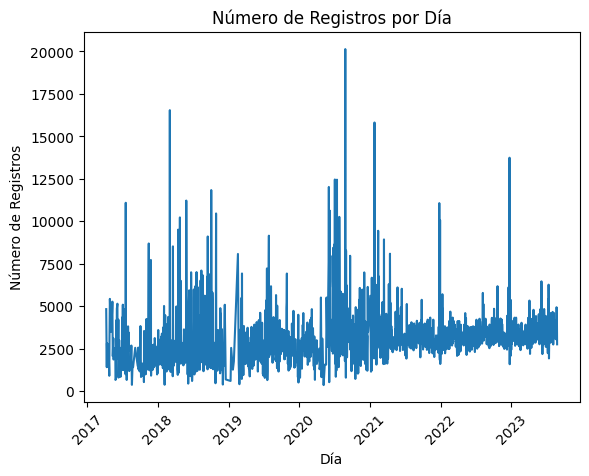

In [186]:
agrupado_por_dia = df_2.groupby(df_2['processedAt2'].dt.date)['totalPriceSet'].mean().reset_index(name='promedio')
agrupado_por_dia['processedAt2'] = pd.to_datetime(agrupado_por_dia['processedAt2'])
sns.lineplot(x="processedAt2", y="promedio",data=agrupado_por_dia)
plt.xlabel('Día')
plt.ylabel('Número de Registros')
plt.title('Número de Registros por Día')
plt.xticks(rotation=45) 

plt.show()

In [177]:
df_2

,id,cancelReason,cancelledAt,closedAt,createdAt,currencyCode,currentTotalPriceSet,id_customer,displayFinancialStatus,displayFulfillmentStatus,paymentGatewayNames,processedAt,shippingAddress,totalDiscountsSet,subtotalLineItemsQuantity,totalPriceSet,processedAt2
0,gid://shopify/Order/5298910265583,None,None,None,2023-08-20T17:24:26Z,MXN,1628.0,gid://shopify/Customer/6965136195823,PAID,UNFULFILLED,[],2017-04-08T00:49:30Z,None,0.0,1,1628.0,2017-04-08 00:49:30+00:00
1,gid://shopify/Order/5298910331119,None,None,None,2023-08-20T17:24:29Z,MXN,8896.5,gid://shopify/Customer/6965136228591,PAID,UNFULFILLED,[],2017-04-08T14:54:46Z,None,0.0,1,8896.5,2017-04-08 14:54:46+00:00
2,gid://shopify/Order/5298910396655,None,None,None,2023-08-20T17:24:32Z,MXN,4000.0,gid://shopify/Customer/6960887070959,PAID,UNFULFILLED,[],2017-04-08T20:07:29Z,None,0.0,1,4000.0,2017-04-08 20:07:29+00:00
3,gid://shopify/Order/5298910462191,None,None,None,2023-08-20T17:24:35Z,MXN,1427.04,gid://shopify/Customer/6960887693551,PAID,UNFULFILLED,[],2017-04-11T18:03:37Z,None,0.0,1,1427.04,2017-04-11 18:03:37+00:00
4,gid://shopify/Order/5298910560495,None,None,None,2023-08-20T17:24:37Z,MXN,2072.11,gid://shopify/Customer/6965136294127,PAID,UNFULFILLED,[],2017-04-12T15:33:00Z,None,0.0,1,2072.11,2017-04-12 15:33:00+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48329,gid://shopify/Order/5305457213679,None,None,None,2023-08-26T06:11:40Z,MXN,1378.0,gid://shopify/Customer/7016039842031,PAID,UNFULFILLED,[],2023-08-26T02:50:17Z,None,0.0,1,1378.0,2023-08-26 02:50:17+00:00
48330,gid://shopify/Order/5305457279215,None,None,None,2023-08-26T06:11:45Z,MXN,1908.0,gid://shopify/Customer/7016039907567,PAID,UNFULFILLED,[],2023-08-26T03:01:55Z,None,0.0,1,1908.0,2023-08-26 03:01:55+00:00
48331,gid://shopify/Order/5305457311983,None,None,None,2023-08-26T06:11:50Z,MXN,8650.0,gid://shopify/Customer/7016039973103,PAID,UNFULFILLED,[],2023-08-26T03:03:23Z,None,0.0,2,8650.0,2023-08-26 03:03:23+00:00
48332,gid://shopify/Order/5305457377519,None,None,None,2023-08-26T06:11:54Z,MXN,2551.98,gid://shopify/Customer/6968468472047,PAID,UNFULFILLED,[],2023-08-26T03:19:35Z,None,0.0,1,2551.98,2023-08-26 03:19:35+00:00


In [170]:
df_1['title'].value_counts()

title
Certificado de regalo                             1232
Certificado                                        976
Cena Romántica                                     688
Apoyo Para Luna De Miel                            457
Vuelos para la Luna de Miel                        396
                                                  ... 
Drinks at Bar 83                                     1
Día en Punta Rucia                                   1
Paseo en Santiago de los 3 Caballeros                1
Aventura turística ecólogica en “Los Haitises”       1
38KOBackgammon-Azul                                  1
Name: count, Length: 4253, dtype: int64

In [171]:
df_2

,id,cancelReason,cancelledAt,closedAt,createdAt,currencyCode,currentTotalPriceSet,id_customer,displayFinancialStatus,displayFulfillmentStatus,paymentGatewayNames,processedAt,shippingAddress,totalDiscountsSet,subtotalLineItemsQuantity,totalPriceSet
0,gid://shopify/Order/5298910265583,None,None,None,2023-08-20T17:24:26Z,MXN,1628.0,gid://shopify/Customer/6965136195823,PAID,UNFULFILLED,[],2017-04-08T00:49:30Z,None,0.0,1,1628.0
1,gid://shopify/Order/5298910331119,None,None,None,2023-08-20T17:24:29Z,MXN,8896.5,gid://shopify/Customer/6965136228591,PAID,UNFULFILLED,[],2017-04-08T14:54:46Z,None,0.0,1,8896.5
2,gid://shopify/Order/5298910396655,None,None,None,2023-08-20T17:24:32Z,MXN,4000.0,gid://shopify/Customer/6960887070959,PAID,UNFULFILLED,[],2017-04-08T20:07:29Z,None,0.0,1,4000.0
3,gid://shopify/Order/5298910462191,None,None,None,2023-08-20T17:24:35Z,MXN,1427.04,gid://shopify/Customer/6960887693551,PAID,UNFULFILLED,[],2017-04-11T18:03:37Z,None,0.0,1,1427.04
4,gid://shopify/Order/5298910560495,None,None,None,2023-08-20T17:24:37Z,MXN,2072.11,gid://shopify/Customer/6965136294127,PAID,UNFULFILLED,[],2017-04-12T15:33:00Z,None,0.0,1,2072.11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48329,gid://shopify/Order/5305457213679,None,None,None,2023-08-26T06:11:40Z,MXN,1378.0,gid://shopify/Customer/7016039842031,PAID,UNFULFILLED,[],2023-08-26T02:50:17Z,None,0.0,1,1378.0
48330,gid://shopify/Order/5305457279215,None,None,None,2023-08-26T06:11:45Z,MXN,1908.0,gid://shopify/Customer/7016039907567,PAID,UNFULFILLED,[],2023-08-26T03:01:55Z,None,0.0,1,1908.0
48331,gid://shopify/Order/5305457311983,None,None,None,2023-08-26T06:11:50Z,MXN,8650.0,gid://shopify/Customer/7016039973103,PAID,UNFULFILLED,[],2023-08-26T03:03:23Z,None,0.0,2,8650.0
48332,gid://shopify/Order/5305457377519,None,None,None,2023-08-26T06:11:54Z,MXN,2551.98,gid://shopify/Customer/6968468472047,PAID,UNFULFILLED,[],2023-08-26T03:19:35Z,None,0.0,1,2551.98
